In [11]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import math
from numpy import log2, zeros, mean, var, sum, loadtxt, arange, \
                  array, cumsum, dot, transpose, diagonal, floor
from numpy.linalg import inv, lstsq
import seaborn as sns
import scipy.cluster.hierarchy
from scipy.spatial.distance import squareform
import sklearn
from sklearn.decomposition import PCA
import itertools
import mdtraj as md


This is a 125 microsecond trajectory of fast folding variant of the Villin Headpiece generated from DEShaw Research:

https://www.science.org/doi/full/10.1126/science.1208351

It can be compared to an X-ray structure:
https://www.rcsb.org/structure/2F4K
(Note that the x-ray structure has multiple positions for some sidechain atoms)

You can download the required files here:
https://www.dropbox.com/s/60jxmiuvlyehbhz/Villin_Lab.zip?dl=0

In [12]:
pdb='/Users/michellegarcia/git/CHEM101.6_S24/Villin_Lab/2F4K.protein.pdb'
trajectory='/Users/michellegarcia/git/CHEM101.6_S24/Villin_Lab/2F4K.protein.s10.dcd'
xray_CA_pdb='/Users/michellegarcia/git/CHEM101.6_S24/Villin_Lab/2f4K.xray.CA.pdb'
outdir='/Users/michellegarcia/git/CHEM101.6_S24/exercise4_output/'
if not os.path.exists(outdir):
    os.makedirs(outdir)
    
print("outdir:",outdir)
print("pdb:",pdb)
print("trjaectory:",trajectory)

outdir: /Users/michellegarcia/git/CHEM101.6_S24/exercise4_output/
pdb: /Users/michellegarcia/git/CHEM101.6_S24/Villin_Lab/2F4K.protein.pdb
trjaectory: /Users/michellegarcia/git/CHEM101.6_S24/Villin_Lab/2F4K.protein.s10.dcd


In [13]:
stride_sel=5
trj = md.load(trajectory, top=pdb,stride=stride_sel)
trj.center_coordinates()
top = trj.topology
first_frame = 0
last_frame = trj.n_frames
n_frames=trj.n_frames
trj_length=125
time=np.linspace(0,125,n_frames)

In [14]:
nres=[]
for res in trj.topology.residues: nres.append(res.resSeq)
sequence=(' %s' % [residue for residue in trj.topology.residues])
resname=(' %s' % [residue.name for residue in trj.topology.residues])
resindex=(' %s' % [residue.index for residue in trj.topology.residues])
res_num=(' %s' % [residue.resSeq  for residue in trj.topology.residues])



#log = open("/Users/paulrobustelli/Desktop/Sa_calc.log", "w")
print("** SYSTEM INFO **\n")
print("Number of atoms: %d\n" % trj.n_atoms)
print("Number of residues: %d\n" % len(set(nres)))
print("Number of frames: %d\n" % trj.n_frames)
print("Starting frame: %d\n" % first_frame)
print("Last frame: %d\n" % last_frame)
print("sequence: %s\n" % sequence)
print("residue names: %s\n" % resname)
print("residue number: %s\n" % res_num)
print("residue index: %s\n" % resindex)


** SYSTEM INFO **

Number of atoms: 577

Number of residues: 35

Number of frames: 12559

Starting frame: 0

Last frame: 12559

sequence:  [LEU42, SER43, ASP44, GLU45, ASP46, PHE47, LYS48, ALA49, VAL50, PHE51, GLY52, MET53, THR54, ARG55, SER56, ALA57, PHE58, ALA59, ASN60, LEU61, PRO62, LEU63, TRP64, NLE65, GLN66, GLN67, HIS68, LEU69, NLE70, LYS71, GLU72, LYS73, GLY74, LEU75, PHE76, LEU42, SER43, ASP44, GLU45, ASP46, PHE47, LYS48, ALA49, VAL50, PHE51, GLY52, MET53, THR54, ARG55, SER56, ALA57, PHE58, ALA59, ASN60, LEU61, PRO62, LEU63, TRP64, NLE65, GLN66, GLN67, HIS68, LEU69, NLE70, LYS71, GLU72, LYS73, GLY74, LEU75, PHE76]

residue names:  ['LEU', 'SER', 'ASP', 'GLU', 'ASP', 'PHE', 'LYS', 'ALA', 'VAL', 'PHE', 'GLY', 'MET', 'THR', 'ARG', 'SER', 'ALA', 'PHE', 'ALA', 'ASN', 'LEU', 'PRO', 'LEU', 'TRP', 'NLE', 'GLN', 'GLN', 'HIS', 'LEU', 'NLE', 'LYS', 'GLU', 'LYS', 'GLY', 'LEU', 'PHE', 'LEU', 'SER', 'ASP', 'GLU', 'ASP', 'PHE', 'LYS', 'ALA', 'VAL', 'PHE', 'GLY', 'MET', 'THR', 'ARG', 'SER', 'A

In [15]:
residue_num=[]
for res in top.residues: 
    residue_num.append(res.resSeq)
residue_id=np.asarray(residue_num)


In [16]:
xray_CA = md.load_pdb(xray_CA_pdb)
top_xray = xray_CA.topology
top_xray
residue_xray=[]
for res in top_xray.residues: 
    residue_xray.append(res.resSeq)
resid_xray=np.asarray(residue_xray)
resid_xray

array([42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58,
       59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75,
       76])

In [17]:
#Use DSSP to calculate the secondary structure definition
#https://mdtraj.org/1.9.4/api/generated/mdtraj.compute_dssp.html
trjBB = md.load(trajectory, top=pdb,stride=stride_sel)
BB=top.select("backbone")
trjBB.restrict_atoms(BB)
trjBB.center_coordinates()

dssp=md.compute_dssp(trjBB,simplified=True)


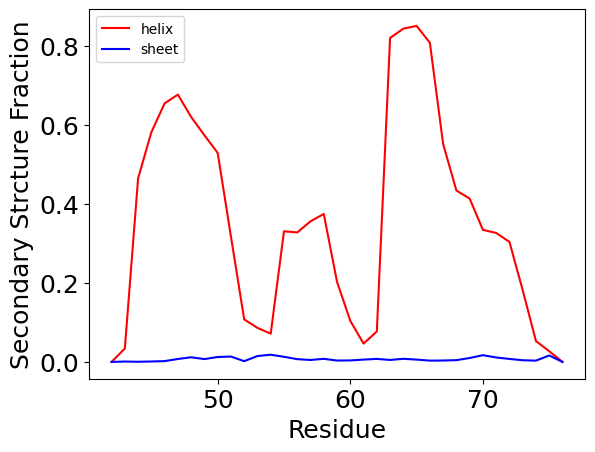

In [18]:
#dssp=md.compute_dssp(trj,simplified=True)

def dssp_convert(dssp):
 dsspH=np.copy(dssp)
 dsspE=np.copy(dssp)
 dsspH[dsspH=='H']=1                                                                                      
 dsspH[dsspH=='E']=0                                                                                      
 dsspH[dsspH=='C']=0                                                                                      
 dsspH[dsspH=='NA']=0 
 dsspH=dsspH.astype(int)
 TotalH=np.sum(dsspH,axis=1) 
 Hprop=np.sum(dsspH,axis=0).astype(float)/len(dsspE) 

 dsspE[dsspE=='H']=0
 dsspE[dsspE=='E']=1
 dsspE[dsspE=='C']=0
 dsspE[dsspE=='NA']=0
 dsspE=dsspE.astype(int)
 TotalE=np.sum(dsspE,axis=1) 
 Eprop=np.sum(dsspE,axis=0).astype(float)/len(dsspE) 
 return Hprop, Eprop

Hprop,Eprop=dssp_convert(dssp)
plt.plot(resid_xray,Hprop,c='r',label='helix')
plt.plot(resid_xray,Eprop,c='b',label='sheet')

plt.legend(loc="upper left")
plt.xlabel('Residue', size=18)
plt.ylabel('Secondary Strcture Fraction', size=18)
plt.tick_params(labelsize=18)


In [19]:
indices_phi, phis = md.compute_phi(trj)
indices_psi, psis = md.compute_psi(trj)
indices_chi1, chi1s = md.compute_chi1(trj)
indices_chi2, chi2s = md.compute_chi2(trj)

In [20]:
phi_dict={}
dihedral_dict = { 'phi': { },
          'psi': { },
          'chi1': { },
          'chi2': { }}

for i in range(0,len(indices_phi)):
  indices=indices_phi[i]
  atom=top.atom(indices[1])
  resnum=top.atom(indices[1]).residue.resSeq
  dihedral_dict['phi'][resnum]=phis[:,i]

for i in range(0,len(indices_psi)):
  indices=indices_psi[i]
  atom=top.atom(indices[1])
  resnum=top.atom(indices[1]).residue.resSeq
  dihedral_dict['psi'][resnum]=psis[:,i]

for i in range(0,len(indices_chi1)):
  indices=indices_chi1[i]
  atom=top.atom(indices[1])
  resnum=top.atom(indices[1]).residue.resSeq
  dihedral_dict['chi1'][resnum]=chi1s[:,i]

for i in range(0,len(indices_chi2)):
  indices=indices_chi2[i]
  atom=top.atom(indices[1])
  resnum=top.atom(indices[1]).residue.resSeq
  dihedral_dict['chi2'][resnum]=chi2s[:,i]

In [21]:
#Heres a function to plot a phi/psi ramachandran plot:

def plot_phipsi(res):
 plt.hist2d(dihedral_dict['phi'][res],dihedral_dict['psi'][res],bins=36,range=[[-3.14,3.14],[-3.14,3.14]], norm=colors.LogNorm(),cmap='jet')
 plt.xlabel('$\phi$', size=18)
 plt.ylabel('$\psi$', size=18)
 plt.xticks([-3.14,-3.14/2,0,3.14/2,3.14],fontsize=35)
 plt.yticks([-3.14,-3.14/2,0,3.14/2,3.14],fontsize=35)
 plt.tick_params(labelsize=18)
 plt.show()
 return

def plot_chi(res):
    if res in dihedral_dict['chi1']:
     plt.hist(dihedral_dict['chi1'][res],bins=36,range=[-3.14,3.14])        
     plt.xticks([-3.14,-3.14/2,0,3.14/2,3.14],fontsize=35)
     plt.xlabel('$\chi_1$', size=18)
     plt.ylabel('counts', size=18)
     plt.tick_params(labelsize=18)
     plt.show()
     plt.clf()   
    if res in dihedral_dict['chi2']:
     plt.hist2d(dihedral_dict['chi1'][res],dihedral_dict['chi2'][res],bins=36,range=[[-3.14,3.14],[-3.14,3.14]], norm=colors.LogNorm(),cmap='jet')
     plt.xlabel('$\chi_1$', size=18)
     plt.ylabel('$\chi_2$', size=18)
     plt.xticks([-3.14,-3.14/2,0,3.14/2,3.14],fontsize=35)
     plt.yticks([-3.14,-3.14/2,0,3.14/2,3.14],fontsize=35)
     plt.tick_params(labelsize=18)
     plt.show()
    return




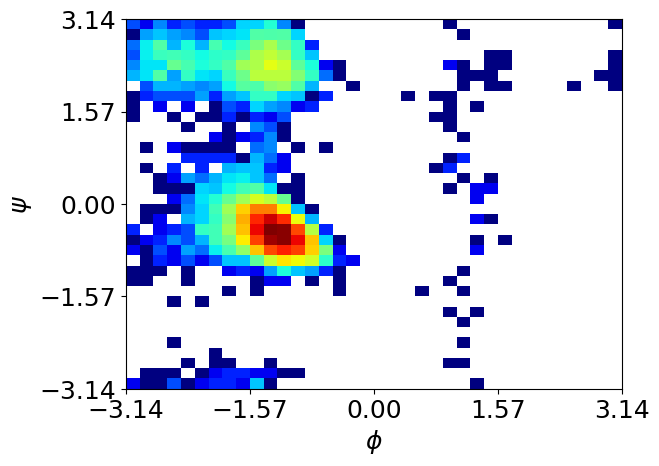

In [22]:
plot_phipsi(45)


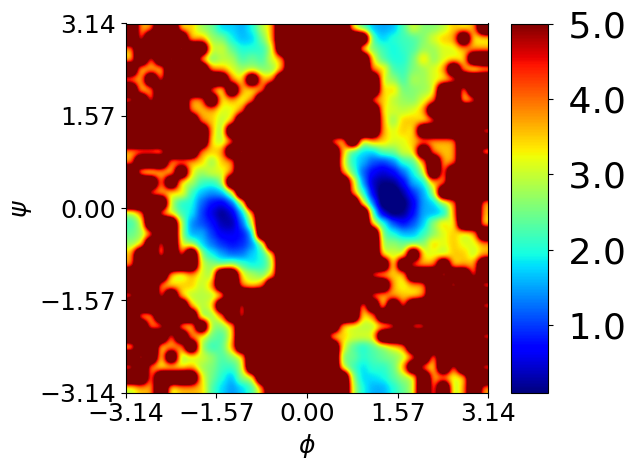

In [23]:
def plot_phipsi_FES(res):
 free_energy,xedges,yedges=np.histogram2d(dihedral_dict['psi'][res],dihedral_dict['phi'][res],36,[[-3.14,3.14],[-3.14,3.14]],density=True,weights=None)
 free_energy=np.log(np.flipud(free_energy)+.000001)
 T=300                                                                                                  
 kbT=T*0.008314/4.184 # kT in kcal/mol
 dG=-(kbT)*free_energy #Convert to kcal/mol
 im=plt.imshow(dG, interpolation='gaussian',extent=[yedges[0], yedges[-1], xedges[0], xedges[-1]],cmap='jet',aspect='auto')
 cbar_ticks=[0,1,2,3,4,5]
 cb = plt.colorbar(ticks=cbar_ticks, format=('% .1f'), aspect=10) # grab the Colorbar instance
 imaxes = plt.gca()                                                                                                 
 plt.xticks([-3.14,-3.14/2,0,3.14/2,3.14],fontsize=35)
 plt.yticks([-3.14,-3.14/2,0,3.14/2,3.14],fontsize=35)
 plt.xlabel('$\phi$', size=18)
 plt.ylabel('$\psi$', size=18)
 plt.tick_params(labelsize=18)
 plt.axes(cb.ax)
 plt.clim(vmin=0.1,vmax=5.0)
 plt.yticks(size='26')
 plt.tight_layout()
 plt.show()
 return

plot_phipsi_FES(52)

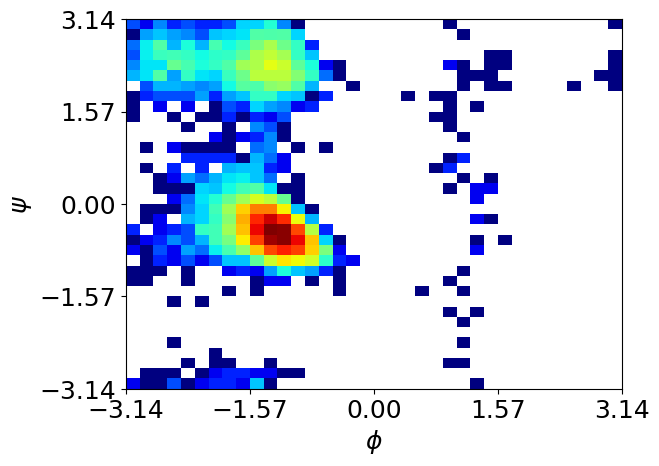

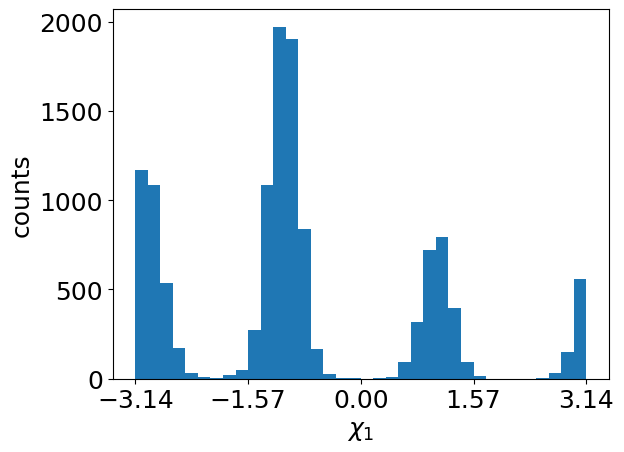

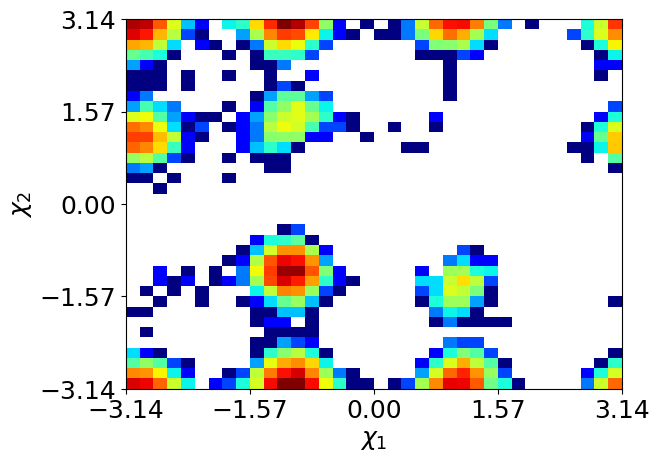

In [24]:
plot_phipsi(45)
plt.clf()
plot_chi(45)

In [25]:
xray_CA = md.load_pdb(xray_CA_pdb)
top_xray = xray_CA.topology
top_xray
residue_xray=[]
for res in top.residues: 
    residue_xray.append(res.resSeq)
resid_xray=np.asarray(residue_xray)
resid_xray

array([42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58,
       59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75,
       76, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57,
       58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74,
       75, 76])

In [26]:
trjCA = md.load(trajectory, top=pdb,stride=stride_sel)
CA=top.select("name CA")
trjCA.restrict_atoms(CA)
trjCA.center_coordinates()

<mdtraj.Trajectory with 12559 frames, 35 atoms, 35 residues, and unitcells at 0x28011da60>

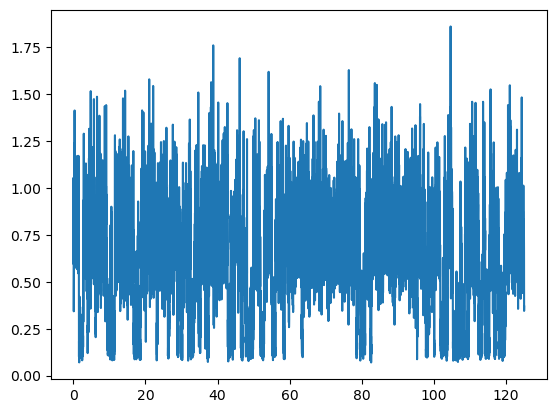

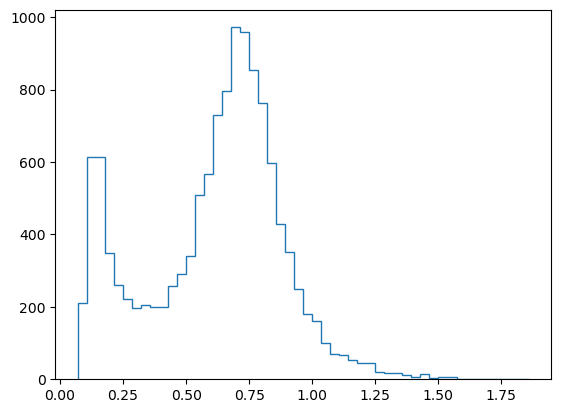

In [27]:
#CA_trj_sel=trj.topology.select("name CA")
#CA_xray_sel=xray_CA.topology.select("name CA")
# get the rmsd from the xray CA 
rmsd = md.rmsd(trjCA,xray_CA)
plt.plot(time,rmsd)
plt.show()
plt.clf()

plt.hist(rmsd,histtype='step',bins=50)
plt.show()

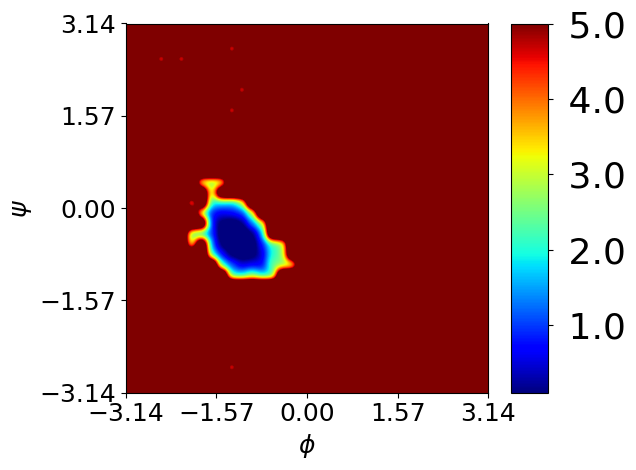

In [28]:
def plot_phipsi_FES_frames(res,frames):
 free_energy,xedges,yedges=np.histogram2d(dihedral_dict['psi'][res][frames],dihedral_dict['phi'][res][frames],36,[[-3.14,3.14],[-3.14,3.14]],density=True,weights=None)
 free_energy=np.log(np.flipud(free_energy)+.000001)
 T=300                                                                                                  
 kbT=T*0.008314/4.184 # kT in kcal/mol
 dG=-(kbT)*free_energy #Convert to kcal/mol
 im=plt.imshow(dG, interpolation='gaussian',extent=[yedges[0], yedges[-1], xedges[0], xedges[-1]],cmap='jet',aspect='auto')
 cbar_ticks=[0,1,2,3,4,5]
 cb = plt.colorbar(ticks=cbar_ticks, format=('% .1f'), aspect=10) # grab the Colorbar instance
 imaxes = plt.gca()                                                                                                 
 plt.xticks([-3.14,-3.14/2,0,3.14/2,3.14],fontsize=35)
 plt.yticks([-3.14,-3.14/2,0,3.14/2,3.14],fontsize=35)
 plt.xlabel('$\phi$', size=18)
 plt.ylabel('$\psi$', size=18)
 plt.tick_params(labelsize=18)
 plt.axes(cb.ax)
 plt.clim(vmin=0.1,vmax=5.0)
 plt.yticks(size='26')
 plt.tight_layout()
 plt.show()
 return


native_frames=np.where(rmsd<0.25)[0]
len(native_frames)
trj[native_frames].save_dcd(outdir+'native.dcd')

plot_phipsi_FES_frames(45,native_frames)


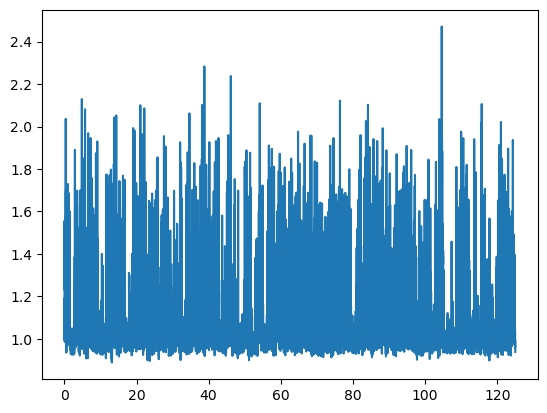

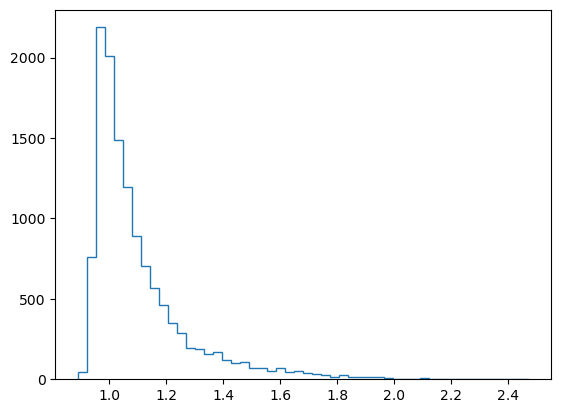

In [29]:
#Lets calculate the radius of gyration
rg=md.compute_rg(trj, masses=None)
plt.plot(time,rg)
plt.show()
plt.clf()

plt.hist(rg,histtype='step',bins=50)
plt.show()

In [30]:
import sklearn
from sklearn.decomposition import PCA

pca1 = PCA(n_components=2)
trj.superpose(trj, 0)
reduced_cartesian = pca1.fit_transform(trj.xyz.reshape(trj.n_frames, trj.n_atoms * 3))
print(reduced_cartesian.shape)

(12559, 2)


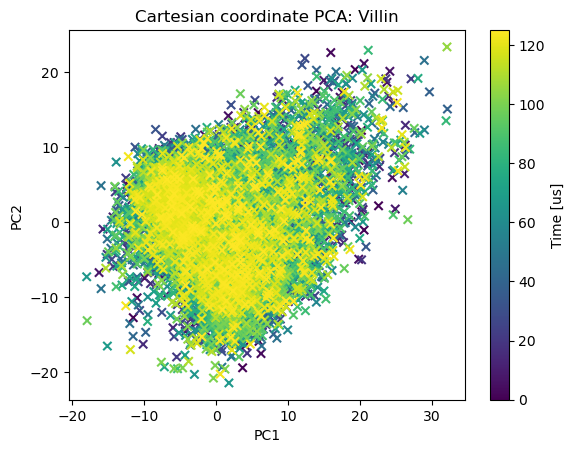

In [31]:
plt.figure()
plt.scatter(reduced_cartesian[:, 0], reduced_cartesian[:,1], marker='x', c=time)
plt.xlabel('PC1')
plt.ylabel('PC2') 
plt.title('Cartesian coordinate PCA: Villin')
cbar = plt.colorbar()
cbar.set_label('Time [us]')

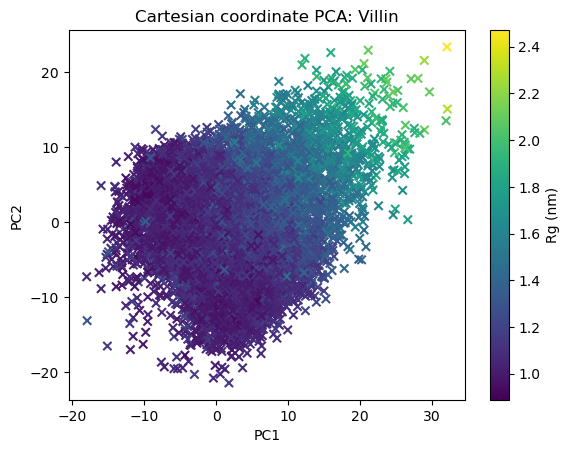

In [32]:
plt.figure()
plt.scatter(reduced_cartesian[:, 0], reduced_cartesian[:,1], marker='x', c=rg)
plt.xlabel('PC1')
plt.ylabel('PC2') 
plt.title('Cartesian coordinate PCA: Villin')
cbar = plt.colorbar()
cbar.set_label('Rg (nm)')

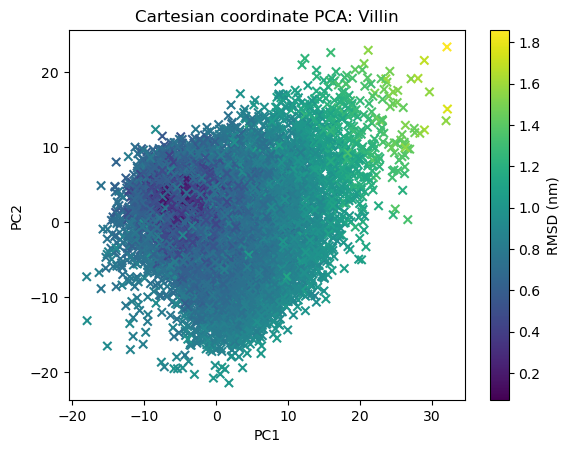

In [33]:
plt.figure()
plt.scatter(reduced_cartesian[:, 0], reduced_cartesian[:,1], marker='x', c=rmsd)
plt.xlabel('PC1')
plt.ylabel('PC2') 
plt.title('Cartesian coordinate PCA: Villin')
cbar = plt.colorbar()
cbar.set_label('RMSD (nm)')

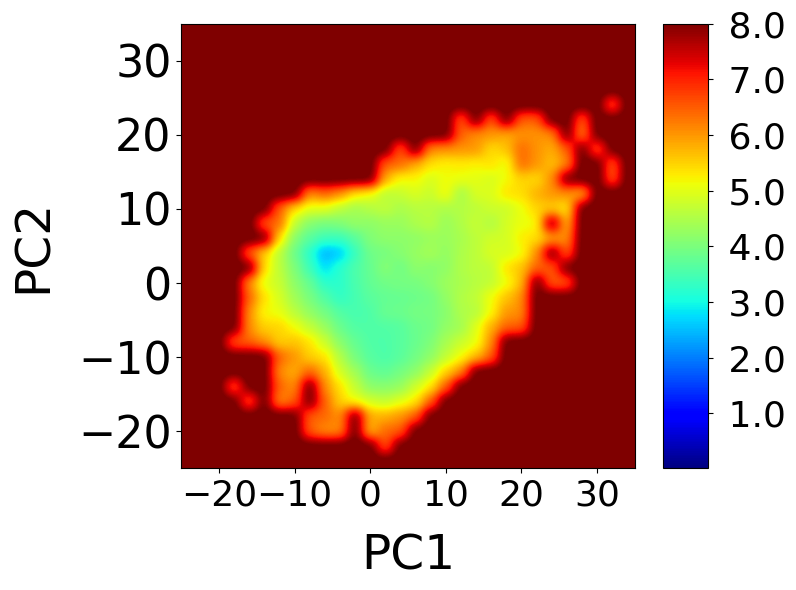

In [34]:
def free_energy(a, b, T, y0, ymax, x0, xmax):
    free_energy, xedges, yedges = np.histogram2d(
        a, b, 30, [[y0, ymax], [x0, xmax]], density=True, weights=None)
    free_energy = np.log(np.flipud(free_energy)+.000001)
    free_energy = -(0.001987*T)*free_energy
    return free_energy, xedges, yedges

PC1=reduced_cartesian[:, 0]
PC2=reduced_cartesian[:,1]

dG,xedges,yedges=free_energy(PC2, PC1, 300, -25, 35, -25, 35)

fig = plt.figure(figsize=(8, 6))
im = plt.imshow(dG, interpolation='gaussian', extent=[
                yedges[0], yedges[-1], xedges[0], xedges[-1]], cmap='jet', aspect='auto')
cbar_ticks = [0, 1, 2, 3, 4, 5,6,7,8]
plt.xlim(-25,35)
cb = plt.colorbar(ticks=cbar_ticks, format=('% .1f'),
                  aspect=10)  # grab the Colorbar instance
imaxes = plt.gca()
plt.ylabel("PC2", size=35, labelpad=15)
plt.xlabel("PC1", size=35, labelpad=15)
plt.xticks(fontsize=35)
plt.yticks(fontsize=35)
plt.xticks(size='26')
plt.yticks(size='32')
plt.axes(cb.ax)
plt.clim(vmin=0.01, vmax=8.0)
plt.yticks(size='26')
plt.tight_layout()

*** Classroom Activitiy: Lets plot the free energy as a function of RMSD***

In [35]:
#Lets Plot Free Energies as a function of RMSD and Rg

def free_energy1D(a,T,x0,xmax,bins):
    free_energy, xedges= np.histogram(
        a, bins, [x0, xmax], density=True, weights=None)
    xcenters= xedges[:-1] + np.diff(xedges)/2
    free_energy = np.log(free_energy+.0000001)
    free_energy = -(0.001987*T)*free_energy
    return free_energy, xcenters



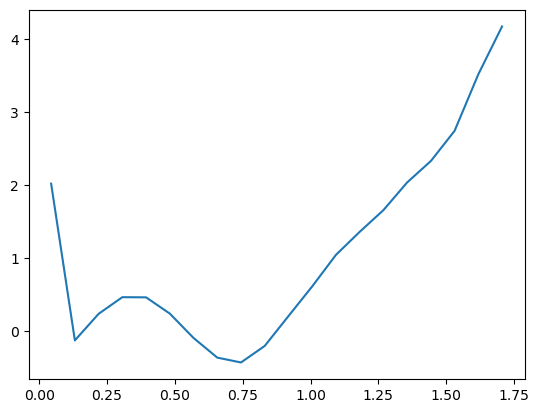

In [36]:
dG_RMSD,xedges=free_energy1D(rmsd,300,0,1.75,20)

plt.plot(xedges,dG_RMSD)

In [37]:
#Possible Homework Prompt:
#Visualize the lowest free energy basin
basin_frames=np.where((rmsd>0.60) & (rmsd<0.80))[0]
len(basin_frames)
trj[basin_frames].save_dcd(outdir+'rmsd.dgmin.basin.dcd')

*** Classroom Activitiy: Lets plot the free energy as a function of Rg vs. RMSD***

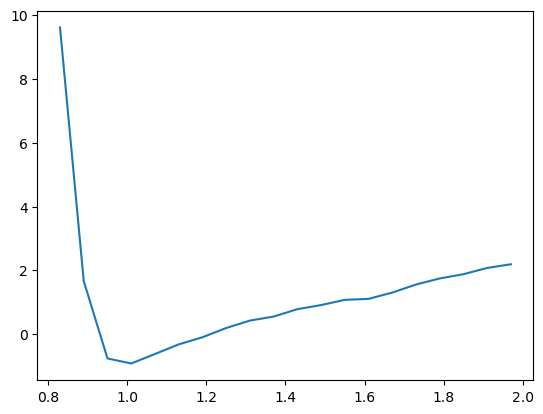

In [38]:
dG_rg,xedges=free_energy1D(rg,300,0.8,2.0,20)

plt.plot(xedges,dG_rg)

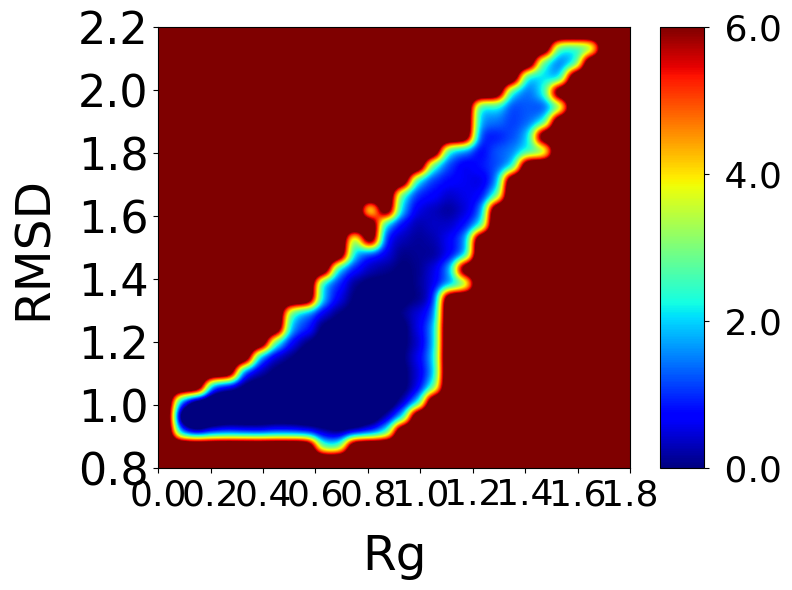

In [39]:
dG,xedges,yedges=free_energy(rg, rmsd, 300, 0.8, 2.2, 0, 1.8)

fig = plt.figure(figsize=(8, 6))
#im = plt.imshow(dG, extent=[
#                yedges[0], yedges[-1], xedges[0], xedges[-1]], cmap='jet', aspect='auto')
im = plt.imshow(dG, interpolation='gaussian', extent=[
                yedges[0], yedges[-1], xedges[0], xedges[-1]], cmap='jet', aspect='auto')
cbar_ticks = [0,2,4,6]
#plt.xlim(-25,35)
cb = plt.colorbar(ticks=cbar_ticks, format=('% .1f'),
                  aspect=10)  # grab the Colorbar instance
imaxes = plt.gca()
plt.ylabel("RMSD", size=35, labelpad=15)
plt.xlabel("Rg", size=35, labelpad=15)
plt.xticks(fontsize=35)
plt.yticks(fontsize=35)
plt.xticks(size='26')
plt.yticks(size='32')
plt.axes(cb.ax)
plt.clim(vmin=0, vmax=6.0)
plt.yticks(size='26')
plt.tight_layout()

In [40]:
#Lets Make a Contact Map
contact_maps = []
contact_distances = []

for i in range(0, 34):
    contact_map = []
    contact_distance = []
    for j in range(0, 34):
        if i == j:
            contacts = 0
        else:
            dist = md.compute_contacts(trj, [[i, j]])
            array = np.asarray(dist[0]).astype(float)
            distance = np.average(array)
            contact_distance.append(distance)
            contact = np.where(array < 0.5, 1, 0)
            contacts = np.average(contact)
        contact_map.append(contacts)
    contact_maps.append(contact_map)
    contact_distances.append(contact_distance)
final_map = np.asarray(contact_maps).astype(float)
final_distance = np.asarray(contact_distances).astype(float)


In [41]:
#Lets Make Nice Contact Map Labels
sequence=[]
for residue in trj.topology.residues:
    sequence.append(residue)
#Lets Zero Out some of the Labels 
n=2
for i in range (0,len(sequence)): 
  if (i % n !=0):
   sequence[i]=''

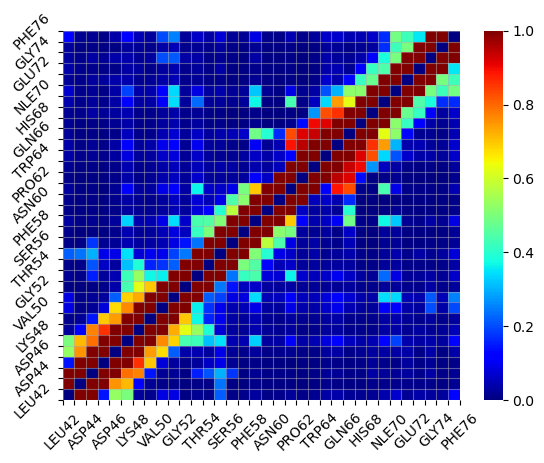

In [42]:
ax = sns.heatmap(final_map, vmin=0.0, vmax=1.0,cmap='jet')
ax.invert_yaxis()
ax.grid(which='both', alpha=0.5)
ax.set_xticks(range(0,35))
ax.set_yticks(range(0,35))
ax.set_xticklabels(sequence[:35],rotation=45)
ax.set_yticklabels(sequence[:35],rotation=45)
plt.show()

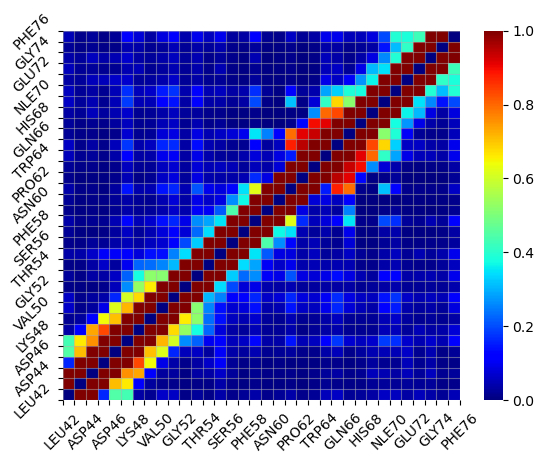

In [43]:
#Lets Make a Contact Map of the low dG Basin 
contact_maps = []
contact_distances = []

for i in range(0, 34):
    contact_map = []
    contact_distance = []
    for j in range(0, 34):
        if i == j:
            contacts = 0
        else:
            dist = md.compute_contacts(trj[basin_frames], [[i, j]])
            array = np.asarray(dist[0]).astype(float)
            distance = np.average(array)
            contact_distance.append(distance)
            contact = np.where(array < 0.5, 1, 0)
            contacts = np.average(contact)
        contact_map.append(contacts)
    contact_maps.append(contact_map)
    contact_distances.append(contact_distance)
final_map = np.asarray(contact_maps).astype(float)
final_distance = np.asarray(contact_distances).astype(float)

ax = sns.heatmap(final_map, vmin=0.0, vmax=1.0,cmap='jet')
ax.invert_yaxis()
ax.grid(which='both', alpha=0.5)
ax.set_xticks(range(0,35))
ax.set_yticks(range(0,35))
ax.set_xticklabels(sequence[:35],rotation=45)
ax.set_yticklabels(sequence[:35],rotation=45)
plt.show()

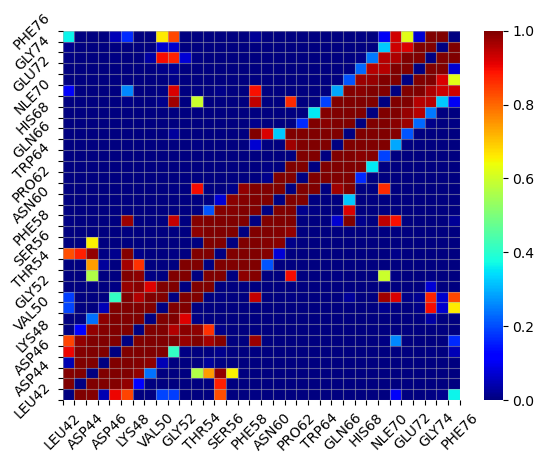

In [44]:
#Lets Make a Contact Map of the native frames
contact_maps = []
contact_distances = []

for i in range(0, 34):
    contact_map = []
    contact_distance = []
    for j in range(0, 34):
        if i == j:
            contacts = 0
        else:
            dist = md.compute_contacts(trj[native_frames], [[i, j]])
            array = np.asarray(dist[0]).astype(float)
            distance = np.average(array)
            contact_distance.append(distance)
            contact = np.where(array < 0.5, 1, 0)
            contacts = np.average(contact)
        contact_map.append(contacts)
    contact_maps.append(contact_map)
    contact_distances.append(contact_distance)
final_map = np.asarray(contact_maps).astype(float)
final_distance = np.asarray(contact_distances).astype(float)

ax = sns.heatmap(final_map, vmin=0.0, vmax=1.0,cmap='jet')
ax.invert_yaxis()
ax.grid(which='both', alpha=0.5)
ax.set_xticks(range(0,35))
ax.set_yticks(range(0,35))
ax.set_xticklabels(sequence[:35],rotation=45)
ax.set_yticklabels(sequence[:35],rotation=45)
plt.show()

In [45]:
def circular_mean(angle):
    return np.arctan2(np.sum(np.sin(angle)),np.sum(np.cos(angle)))


def circular_corr(angle1,angle2):
    cmean1=circular_mean(angle1)
    cmean2=circular_mean(angle2)
    numerator=(np.sum(np.sin(angle1-cmean1)*np.sin(angle2-cmean2)))
    denom=((np.sum(np.sin(angle1-cmean1)**2)*np.sum(np.sin(angle2-cmean2)**2))**.5)
    ccor=numerator/denom
    return ccor

In [46]:
# Make correlation contact map
correlation_maps = []
for i in range(43, 76):
    cor_map = []
    for j in range(43, 76):
        phi=dihedral_dict['phi'][i]
        psi=dihedral_dict['psi'][j]
        ccor=circular_corr(psi,phi)
        cor_map.append(ccor)
    correlation_maps.append(cor_map)
final_cor_map = np.asarray(correlation_maps).astype(float)
np.shape(final_cor_map)

(33, 33)

In [47]:
sequence=[]
for residue in trj.topology.residues:
    sequence.append(residue)
len(sequence)
seq_trunc=sequence[1:34]
#Lets Zero Out some of the Labels 
n=2
for i in range (0,33): 
  if (i % n !=0):
   seq_trunc[i]=''

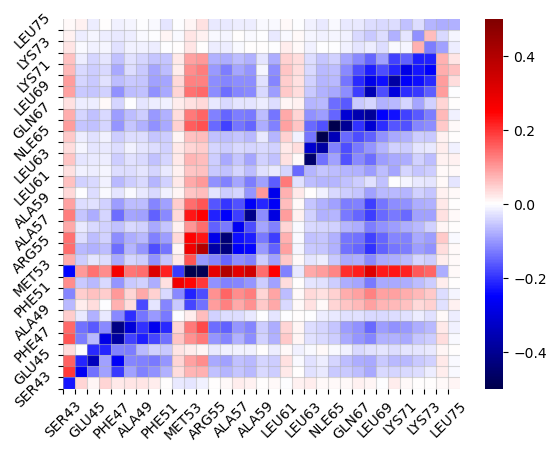

In [48]:
mask = np.zeros_like(final_map)
zeros=np.where((final_map<0.10) & (final_map>-0.10))
mask[zeros] = True
ax = sns.heatmap(final_cor_map, vmin=-0.5, vmax=0.5,cmap='seismic')
ax.invert_yaxis()
ax.grid(which='both', alpha=0.5)
ax.set_xticks(range(0,33))
ax.set_yticks(range(0,33))
ax.set_xticklabels(seq_trunc,rotation=45)
ax.set_yticklabels(seq_trunc,rotation=45)
plt.show()

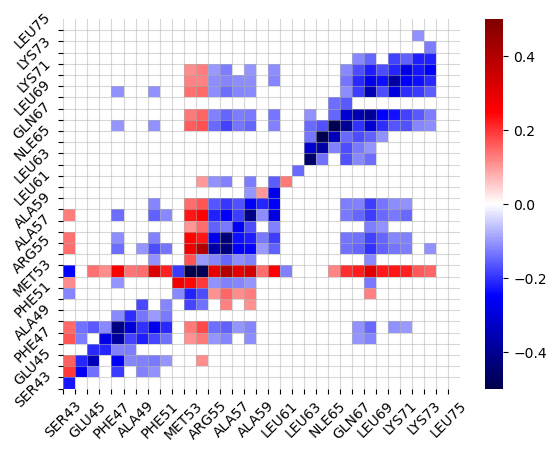

In [49]:
mask = np.zeros_like(final_cor_map)
zeros=np.where((final_cor_map<0.10) & (final_cor_map>-0.10))
mask[zeros] = True
ax = sns.heatmap(final_cor_map,mask=mask, vmin=-0.5, vmax=0.5,cmap='seismic')
ax.invert_yaxis()
ax.grid(which='both', alpha=0.5)
ax.set_xticks(range(0,33))
ax.set_yticks(range(0,33))
ax.set_xticklabels(seq_trunc,rotation=45)
ax.set_yticklabels(seq_trunc,rotation=45)
plt.show()

We want to try to Reproduce the Free Energy Plot From
https://www.science.org/doi/full/10.1126/science.1208351

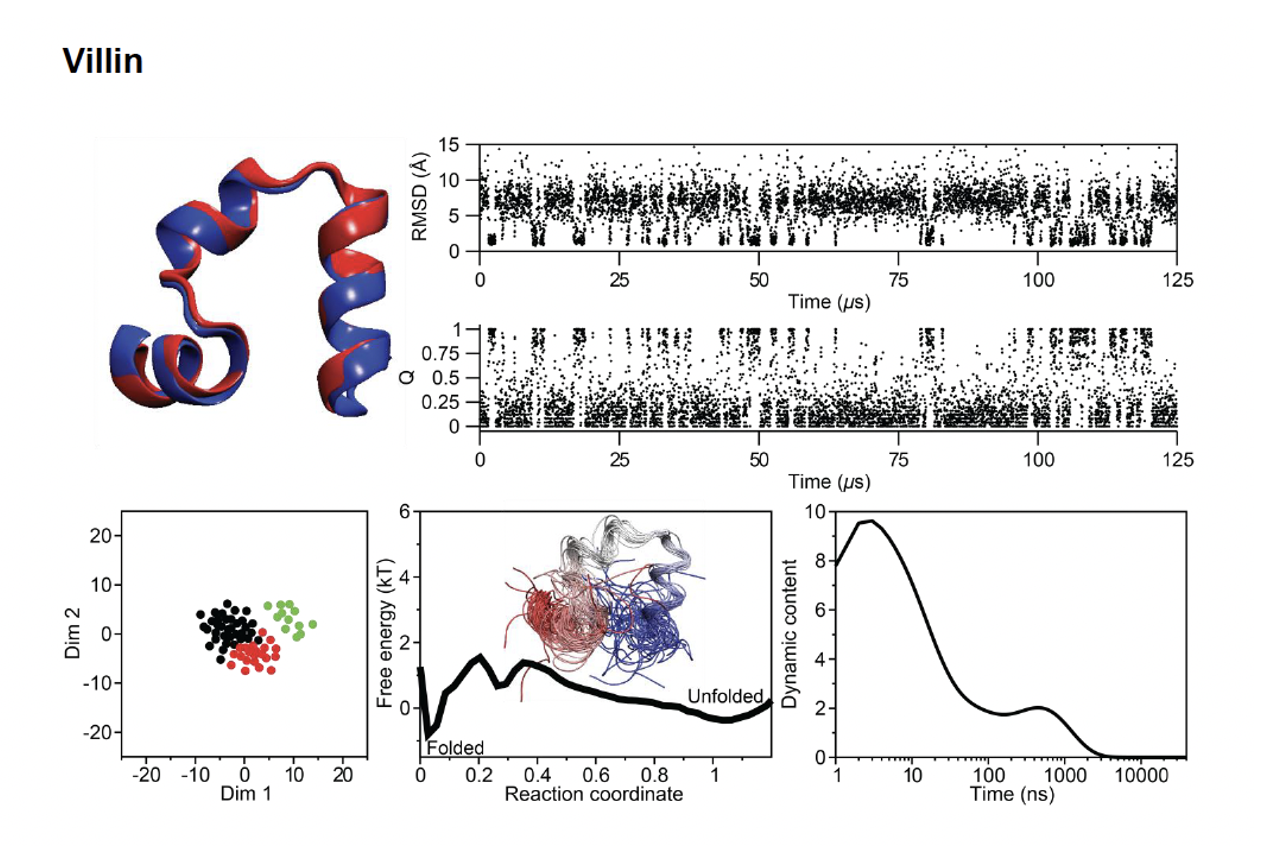

First we need to determine the native contacts and calculate Q

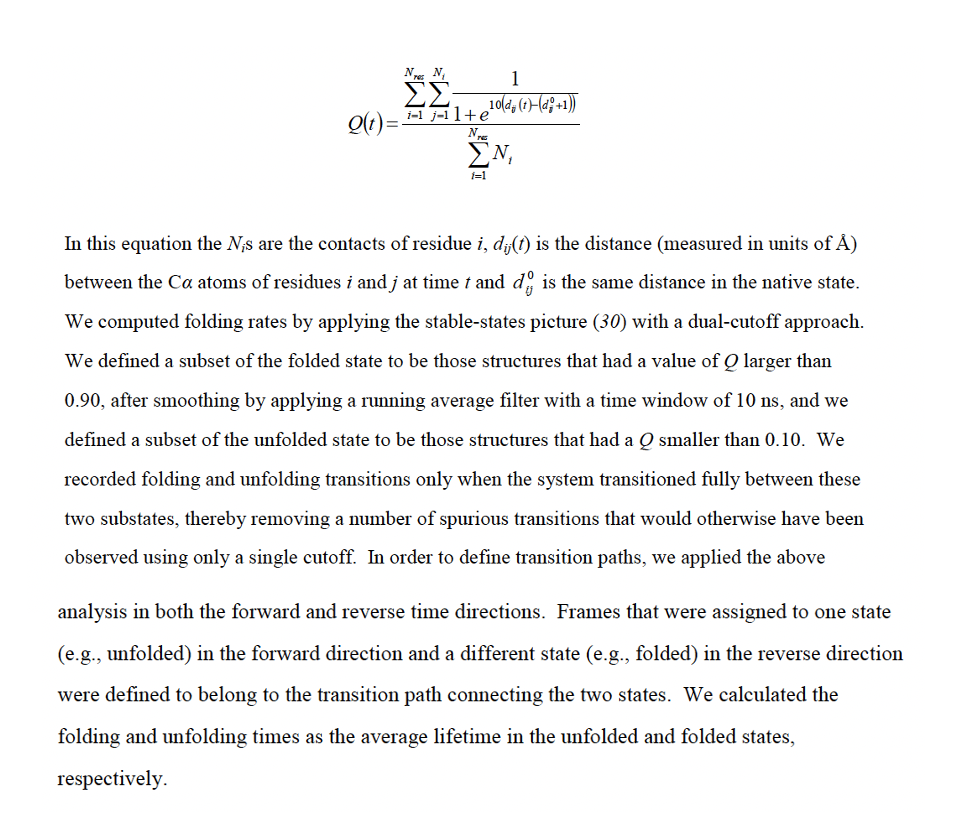

In [50]:
#Lets Make a 1D array that contains all native distances pairs:
xray_CA

<mdtraj.Trajectory with 1 frames, 35 atoms, 35 residues, and unitcells at 0x2801197f0>

In [51]:
native_distance_matrix1D=[]
for i in range(0,34):
 for j in range(0, 34):
  if(abs(i-j)>7):
   #print(i,j)
   dist=md.compute_distances(xray_CA,[[i,j]])[0][0]
   native_distance_matrix1D.append(dist)

#Convert to Angstrom
native_distance_matrix1D=np.asarray(native_distance_matrix1D)*10

In [52]:
Native_Contacts=np.where(native_distance_matrix1D<10)
Native_Contact_Distances=native_distance_matrix1D[Native_Contacts]
np.shape(Native_Contact_Distances)

(148,)

In [53]:
traj_CA_distance_matrix1D=[]
for i in range(0,34):
 for j in range(0, 34):
  if(abs(i-j)>7):
   dist=md.compute_distances(trjCA,[[i,j]])[:,0]
   traj_CA_distance_matrix1D.append(dist)

#Convert to Angstrom
traj_CA_distance_matrix1D=np.asarray(traj_CA_distance_matrix1D)*10
Traj_Native_Contact_Distances=traj_CA_distance_matrix1D[Native_Contacts]


In [54]:
traj_CA_distance_matrix1D=[]
for i in range(0,34):
 for j in range(0, 34):
  if(abs(i-j)>7):
   dist=md.compute_distances(trjCA,[[i,j]])[:,0]
   traj_CA_distance_matrix1D.append(dist)

#Convert to Angstrom
traj_CA_distance_matrix1D=np.asarray(traj_CA_distance_matrix1D)*10

In [55]:
#Select Only the Frames with low RMSD from native state
trj_native_distances=traj_CA_distance_matrix1D[:,native_frames]
np.shape(trj_native_distances)

(702, 2054)

In [56]:
np.shape(Traj_Native_Contact_Distances)

(148, 12559)

In [57]:
for i in range(0,len(Native_Contact_Distances)):
  print(Native_Contact_Distances[i],Traj_Native_Contact_Distances[i])

9.288557 [16.155031 14.692731 10.791452 ... 13.44309  11.834915 12.631355]
9.985726 [11.540491 15.242111 20.317595 ... 11.133914  9.802909  9.529006]
9.704253 [11.477718 13.614361 20.877588 ...  8.659006  7.637048  7.693935]
9.60349 [ 9.620813  14.315687  13.511494  ...  9.546892   7.7607603  7.720747 ]
7.0967283 [ 8.358078  12.062386  16.181501  ...  6.1711082  5.2470694  5.1262226]
7.0852814 [10.051856  10.599729  18.739012  ...  5.1992693  5.975244   5.3546863]
9.99271 [13.804028 13.680305 21.581156 ...  7.900141  8.840288  8.60963 ]
9.574567 [12.595353  16.094152  12.5168705 ...  8.90573    9.433759   9.204168 ]
8.303897 [11.918608 14.237659 15.800192 ...  6.660173  8.140754  7.861574]
9.653462 [13.711605  13.591568  17.694164  ...  7.4799404  9.589137   8.898192 ]
9.792494 [17.497013 16.80119  20.938164 ... 10.491154 12.478381 12.31331 ]
9.633482 [12.349012 15.875407 14.908751 ...  8.254533  8.746978  8.578752]
7.2052145 [18.622604 18.50881  19.704548 ... 11.794368 12.8717   12.52

In [58]:
#Expand Native Distance Matrix so that its the same number of frames as the trajectory
Native_Contact_Distances_nframes=np.zeros(np.shape(Traj_Native_Contact_Distances))
for i in range(0,len(Native_Contact_Distances)):
    Native_Contact_Distances_nframes[i]=Native_Contact_Distances[i]

In [59]:
averages=np.average(trj_native_distances,axis=1)
Native_Contacts=np.where(averages<10.0)[0]
Native_Contacts

array([  5,  29,  30,  52,  53,  54,  55,  75,  76,  77,  98,  99, 120,
       123, 193, 196, 198, 211, 212, 215, 239, 240, 257, 258, 259, 260,
       275, 276, 277, 278, 279, 280, 296, 337, 341, 344, 500, 521, 550,
       557, 569, 570, 635, 636, 684, 701])

In [60]:
Native_CA_Distances=native_distance_matrix1D[Native_Contacts]
Traj_CA_Distnaces=traj_CA_distance_matrix1D[Native_Contacts]
#Expand Native Distance Matrix so that its the same number of frames as the trajectory
Native_Contact_Distances_nframes=np.zeros(np.shape(Traj_CA_Distnaces))
for i in range(0,len(Native_CA_Distances)):
 Native_Contact_Distances_nframes[i]=Native_CA_Distances[i]

np.shape(Native_Contact_Distances_nframes)

(46, 12559)

In [61]:
for i in range(0,len(Native_CA_Distances)):
  print(Native_CA_Distances[i],Traj_CA_Distnaces[i])

9.985726 [11.540491 15.242111 20.317595 ... 11.133914  9.802909  9.529006]
10.452459 [ 9.374432 15.550833 18.456451 ...  9.84092   8.556069  8.788097]
9.704253 [11.477718 13.614361 20.877588 ...  8.659006  7.637048  7.693935]
9.60349 [ 9.620813  14.315687  13.511494  ...  9.546892   7.7607603  7.720747 ]
7.0967283 [ 8.358078  12.062386  16.181501  ...  6.1711082  5.2470694  5.1262226]
7.0852814 [10.051856  10.599729  18.739012  ...  5.1992693  5.975244   5.3546863]
9.99271 [13.804028 13.680305 21.581156 ...  7.900141  8.840288  8.60963 ]
9.574567 [12.595353  16.094152  12.5168705 ...  8.90573    9.433759   9.204168 ]
8.303897 [11.918608 14.237659 15.800192 ...  6.660173  8.140754  7.861574]
9.653462 [13.711605  13.591568  17.694164  ...  7.4799404  9.589137   8.898192 ]
9.633482 [12.349012 15.875407 14.908751 ...  8.254533  8.746978  8.578752]
10.225195 [14.985344 15.004972 16.675589 ...  8.071144  9.364284  8.658443]
6.8318415 [12.484558  12.280922  14.192814  ...  5.4976153  6.584661

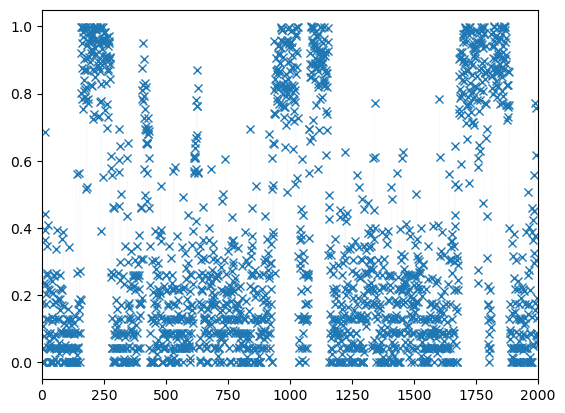

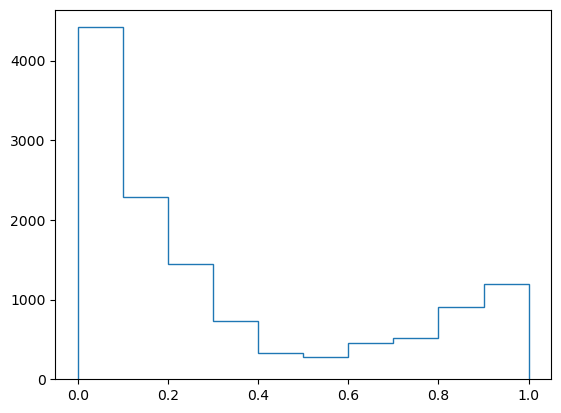

In [62]:
Q=1/(1+np.exp(10*(Traj_CA_Distnaces-(Native_Contact_Distances_nframes+1))))
Q_sum=np.sum(Q,axis=0)
Q_sum=np.sum(Q,axis=0)
Q=Q_sum/len(Native_CA_Distances)
plt.plot(Q,marker='x',linewidth=.01)
plt.xlim(0,2000)
plt.show()
plt.clf()
plt.hist(Q,histtype='step')
plt.show()

In [63]:
#Now Lets Consider a "Native Portion of the Trajectory"
native_frames

array([  158,   159,   160, ..., 12022, 12023, 12027])

In [64]:
native_distance_matrix1D=[]
for i in range(0,34):
 for j in range(0, 34):
  if(abs(i-j)>7):
   #print(i,j)
   dist=md.compute_distances(xray_CA,[[i,j]])[0][0]
   native_distance_matrix1D.append(dist)

#Convert to Angstrom
native_distance_matrix1D=np.asarray(native_distance_matrix1D)*10


In [65]:
np.shape(native_distance_matrix1D)

(702,)

In [66]:
np.shape(traj_CA_distance_matrix1D)

(702, 12559)

In [67]:
#Select Only the Frames with low RMSD from native state
trj_native_distances=traj_CA_distance_matrix1D[:,native_frames]
np.shape(trj_native_distances)

(702, 2054)

In [68]:
averages=np.average(trj_native_distances,axis=1)
Native_Contacts=np.where(averages<10.0)[0]
Native_Contacts

array([  5,  29,  30,  52,  53,  54,  55,  75,  76,  77,  98,  99, 120,
       123, 193, 196, 198, 211, 212, 215, 239, 240, 257, 258, 259, 260,
       275, 276, 277, 278, 279, 280, 296, 337, 341, 344, 500, 521, 550,
       557, 569, 570, 635, 636, 684, 701])

In [69]:
Native_CA_Distances=native_distance_matrix1D[Native_Contacts]
Traj_CA_Distnaces=traj_CA_distance_matrix1D[Native_Contacts]
#Expand Native Distance Matrix so that its the same number of frames as the trajectory
Native_Contact_Distances_nframes=np.zeros(np.shape(Traj_CA_Distnaces))
for i in range(0,len(Native_CA_Distances)):
 Native_Contact_Distances_nframes[i]=Native_CA_Distances[i]

np.shape(Native_Contact_Distances_nframes)

(46, 12559)

In [70]:
for i in range(0,len(Native_CA_Distances)):
  print(Native_CA_Distances[i],Traj_CA_Distnaces[i])

9.985726 [11.540491 15.242111 20.317595 ... 11.133914  9.802909  9.529006]
10.452459 [ 9.374432 15.550833 18.456451 ...  9.84092   8.556069  8.788097]
9.704253 [11.477718 13.614361 20.877588 ...  8.659006  7.637048  7.693935]
9.60349 [ 9.620813  14.315687  13.511494  ...  9.546892   7.7607603  7.720747 ]
7.0967283 [ 8.358078  12.062386  16.181501  ...  6.1711082  5.2470694  5.1262226]
7.0852814 [10.051856  10.599729  18.739012  ...  5.1992693  5.975244   5.3546863]
9.99271 [13.804028 13.680305 21.581156 ...  7.900141  8.840288  8.60963 ]
9.574567 [12.595353  16.094152  12.5168705 ...  8.90573    9.433759   9.204168 ]
8.303897 [11.918608 14.237659 15.800192 ...  6.660173  8.140754  7.861574]
9.653462 [13.711605  13.591568  17.694164  ...  7.4799404  9.589137   8.898192 ]
9.633482 [12.349012 15.875407 14.908751 ...  8.254533  8.746978  8.578752]
10.225195 [14.985344 15.004972 16.675589 ...  8.071144  9.364284  8.658443]
6.8318415 [12.484558  12.280922  14.192814  ...  5.4976153  6.584661

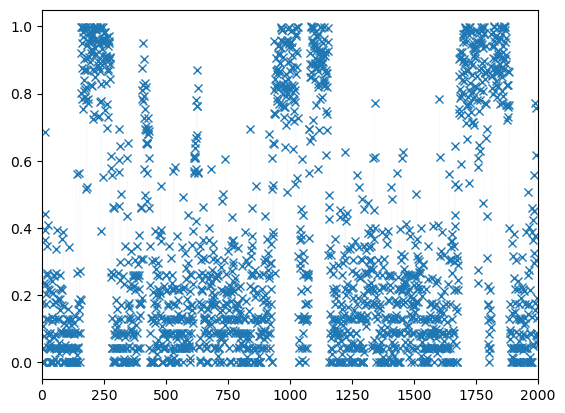

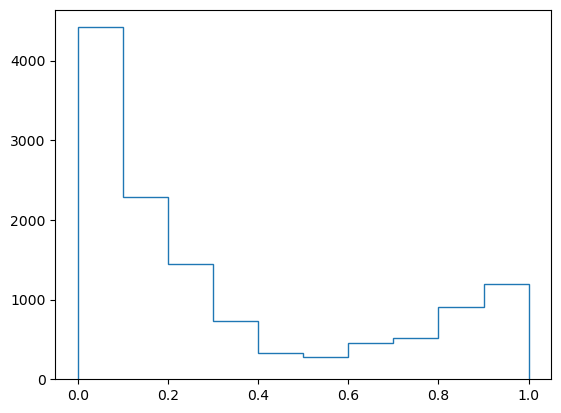

In [71]:
Q=1/(1+np.exp(10*(Traj_CA_Distnaces-(Native_Contact_Distances_nframes+1))))
Q_sum=np.sum(Q,axis=0)
Q_sum=np.sum(Q,axis=0)
Q=Q_sum/len(Native_CA_Distances)
plt.plot(Q,marker='x',linewidth=.01)
plt.xlim(0,2000)
plt.show()
plt.clf()
plt.hist(Q,histtype='step')
plt.show()

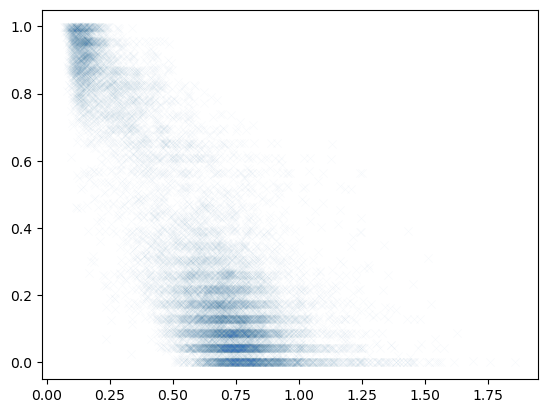

In [72]:
#Plot Q and a Histogram
plt.scatter(rmsd,Q,marker='x',linewidth=.01)

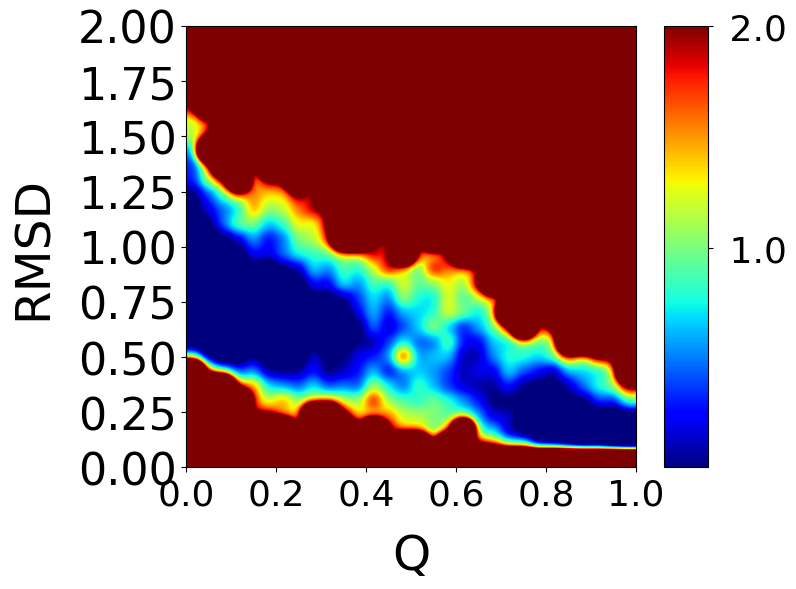

In [73]:
dG,xedges,yedges=free_energy(rmsd, Q, 300, 0, 2.0, 0, 1)

fig = plt.figure(figsize=(8, 6))
#im = plt.imshow(dG, extent=[
#                yedges[0], yedges[-1], xedges[0], xedges[-1]], cmap='jet', aspect='auto')
im = plt.imshow(dG, interpolation='gaussian', extent=[
                yedges[0], yedges[-1], xedges[0], xedges[-1]], cmap='jet', aspect='auto')
cbar_ticks = [0,1,2]
#plt.xlim(-25,35)
cb = plt.colorbar(ticks=cbar_ticks, format=('% .1f'),
                  aspect=10)  # grab the Colorbar instance
imaxes = plt.gca()
plt.ylabel("RMSD", size=35, labelpad=15)
plt.xlabel("Q", size=35, labelpad=15)
plt.xticks(fontsize=35)
plt.yticks(fontsize=35)
plt.xticks(size='26')
plt.yticks(size='32')
plt.axes(cb.ax)
plt.clim(vmin=0.01, vmax=2.0)
plt.yticks(size='26')
plt.tight_layout()

Text(0, 0.5, '$\\Delta$G')

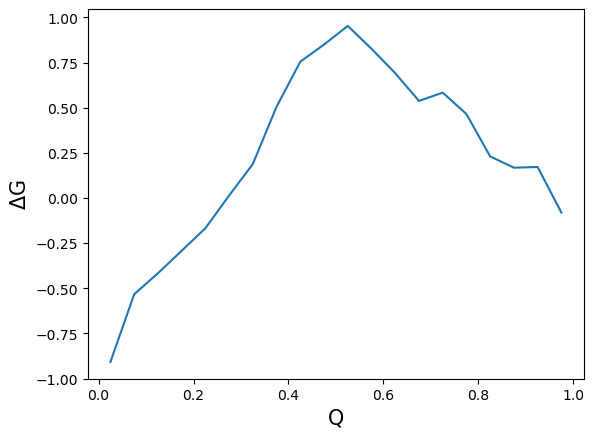

In [74]:
dG_Q,xedges=free_energy1D(Q,300,0,1,20)

plt.plot(xedges,dG_Q)
plt.xlabel("Q",size=15)
plt.ylabel("$\Delta$G",size=15)

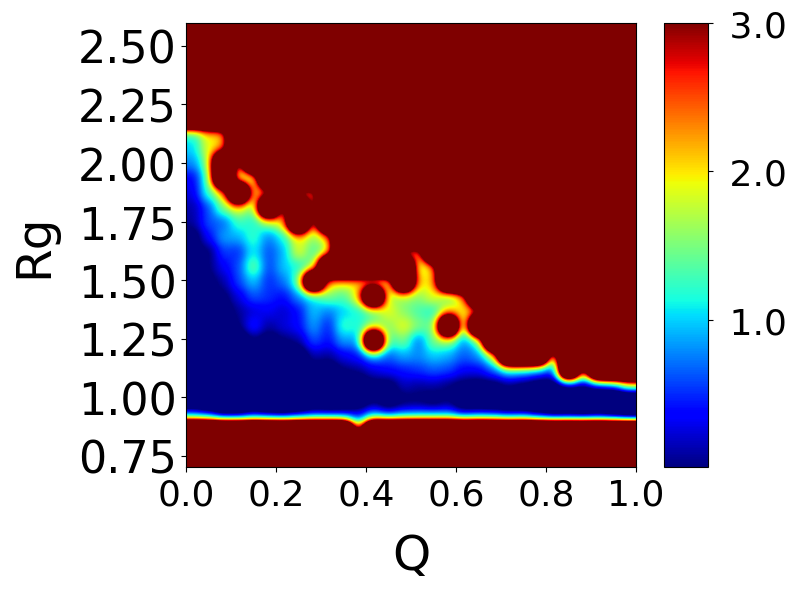

In [75]:
dG,xedges,yedges=free_energy(rg, Q, 300, 0.7, 2.6, 0, 1)

fig = plt.figure(figsize=(8, 6))
#im = plt.imshow(dG, extent=[
#                yedges[0], yedges[-1], xedges[0], xedges[-1]], cmap='jet', aspect='auto')
im = plt.imshow(dG, interpolation='gaussian', extent=[
                yedges[0], yedges[-1], xedges[0], xedges[-1]], cmap='jet', aspect='auto')
cbar_ticks = [0, 1, 2,3]
#plt.xlim(-25,35)
cb = plt.colorbar(ticks=cbar_ticks, format=('% .1f'),
                  aspect=10)  # grab the Colorbar instance
imaxes = plt.gca()
plt.ylabel("Rg", size=35, labelpad=15)
plt.xlabel("Q", size=35, labelpad=15)
plt.xticks(fontsize=35)
plt.yticks(fontsize=35)
plt.xticks(size='26')
plt.yticks(size='32')
plt.axes(cb.ax)
plt.clim(vmin=0.01, vmax=3.0)
plt.yticks(size='26')
plt.tight_layout()

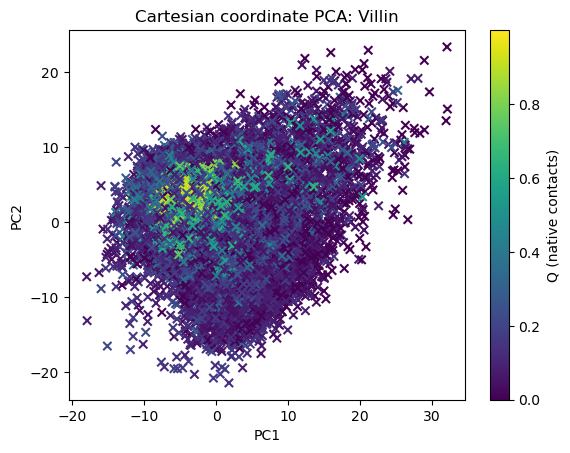

In [76]:
### plt.figure()
plt.scatter(reduced_cartesian[:, 0], reduced_cartesian[:,1], marker='x', c=Q)
plt.xlabel('PC1')
plt.ylabel('PC2') 
plt.title('Cartesian coordinate PCA: Villin')
cbar = plt.colorbar()
cbar.set_label('Q (native contacts)')

In [77]:
# Q1: Now Lets Filter Our Distances based on only the "Native Portion of the Trajectory" and recompute Q
native_frames

array([  158,   159,   160, ..., 12022, 12023, 12027])

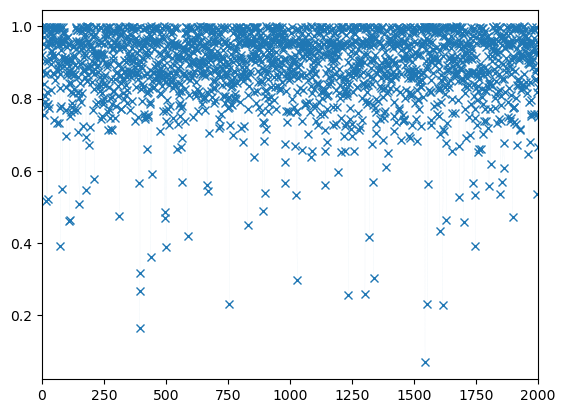

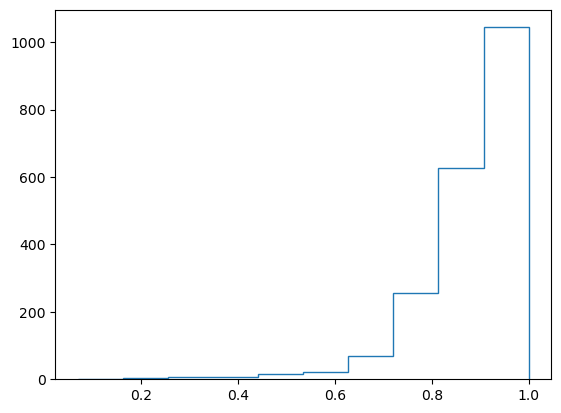

In [78]:
# recompute Q based off of native frames 
Q=1/(1+np.exp(10*(Traj_CA_Distnaces[:,native_frames]-(Native_Contact_Distances_nframes+1)[:,native_frames])))
Q_sum=np.sum(Q,axis=0)
Q_sum=np.sum(Q,axis=0)
Q=Q_sum/len(Native_CA_Distances)
plt.plot(Q,marker='x',linewidth=.01)
plt.xlim(0,2000)
plt.show()
plt.clf()
plt.hist(Q,histtype='step')
plt.show()

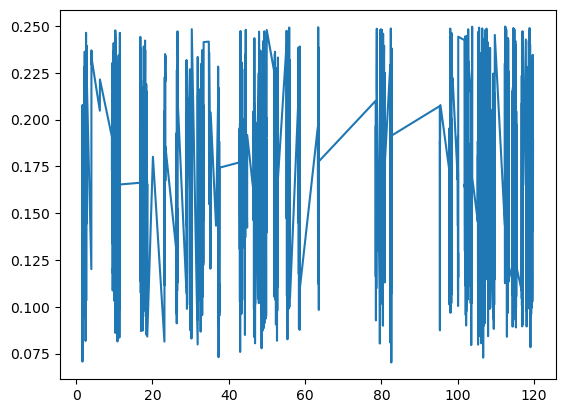

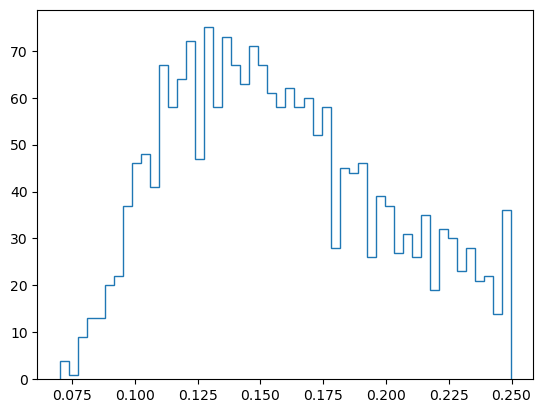

In [79]:
#Select Only the Frames with low RMSD from native state for the native distances
rmsd = md.rmsd(trjCA.slice(native_frames),xray_CA)
plt.plot(time[native_frames],rmsd)
plt.show()
plt.clf()

plt.hist(rmsd,histtype='step',bins=50)
plt.show()


In [80]:
#Check that we're comparing all the correct distances 

In [81]:
#Plot Q using only our native frames


In [82]:
#Lets Calculate Our Transition Paths using the Dual Cutoff Approach 

In [83]:
#Consider using a windowing function to smooth our vlaues of Q for Transition Path Calculations


The only required task is using the dual-cutoff approach (describe in the SI of "How Fast Folding Proteins Fold". To calculate the locations of transition paths in the trajectory & compute something about transition states (helical content, distance between key native contacts) and demonstrate how it compares to the unfolded state.

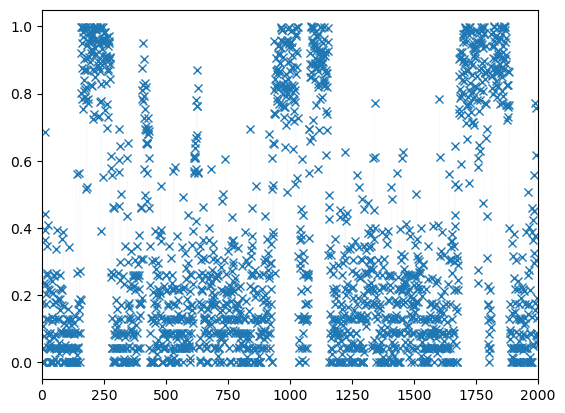

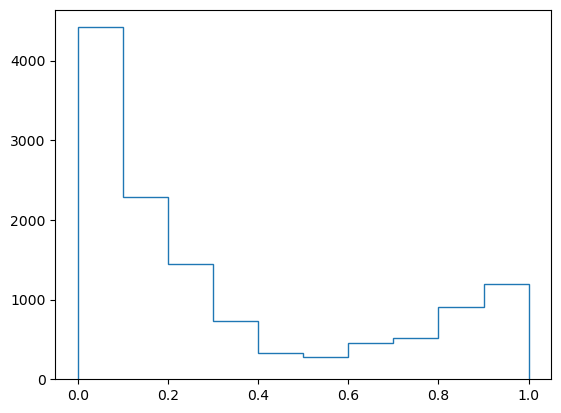

In [84]:
Q=1/(1+np.exp(10*(Traj_CA_Distnaces-(Native_Contact_Distances_nframes+1))))
Q_sum=np.sum(Q,axis=0)
Q_sum=np.sum(Q,axis=0)
Q=Q_sum/len(Native_CA_Distances)
plt.plot(Q,marker='x',linewidth=.01)
plt.xlim(0,2000)
plt.show()
plt.clf()
plt.hist(Q,histtype='step')
plt.show()

In [85]:
# find when Q > 0.90

# Q greater than 0.90
folded_forward = np.where(Q > 0.90)[0]
unfolded_forward = np.where(Q < 0.10)[0]

In [86]:
print(len(folded_forward), len(unfolded_forward))

1190 4417


In [87]:
traj_rev = Traj_CA_Distnaces[::-1]
Q_rev=1/(1+np.exp(10*(traj_rev-(Native_Contact_Distances_nframes+1))))
folded_reverse = np.where(Q_rev > 0.90)[0]
unfolded_reverse = np.where(Q_rev < 0.10)[0]

In [88]:
print(len(folded_forward), len(unfolded_forward))

1190 4417


In [89]:
Native_Contact_Distances_nframes.shape

(46, 12559)

In [90]:
time = np.linspace(0, 12558, 12559)  # time points


In [91]:
# Define cutoff thresholds
folded_threshold = 0.9
unfolded_threshold = 0.1
# Step 3: Identify transitions dynamically
transitions = []
in_transition = False
start_time = None
for i in range(1, len(Q)):
    if Q[i-1] > folded_threshold and Q[i] < unfolded_threshold:
        if not in_transition:
            start_time = time[i-1]
            in_transition = True
    elif in_transition and Q[i] < unfolded_threshold:
        end_time = time[i]
        transitions.append((start_time, end_time))
        in_transition = False

In [92]:
transitions

[(10661.0, 10706.0)]

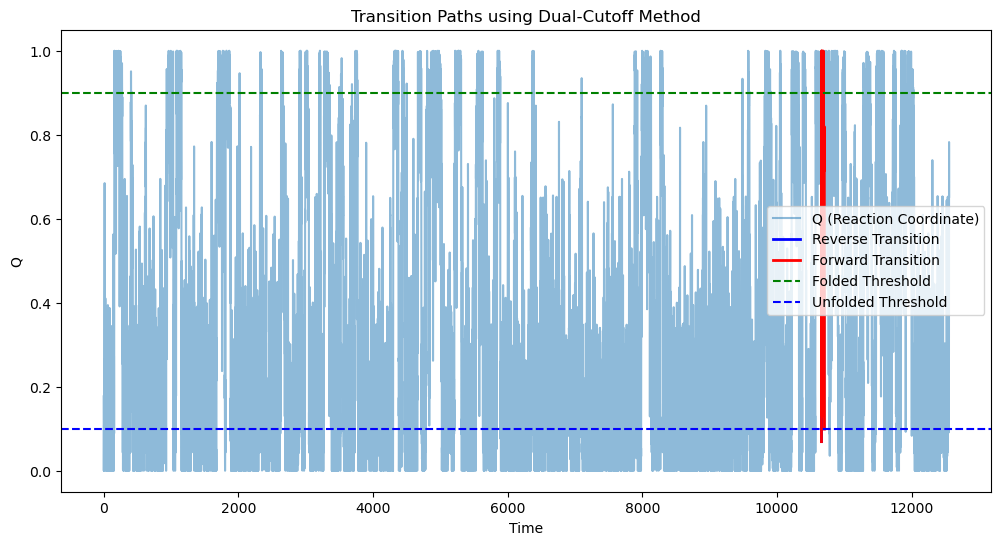

In [93]:
# Define cutoff thresholds
folded_threshold = 0.9
unfolded_threshold = 0.1
# Step 3: Identify transitions dynamically
transitions = []
in_forward_transition = False
in_reverse_transition = False
start_time = None
for i in range(1, len(Q)):
    # Forward transition: Q > 0.9 to Q < 0.1
    if not in_forward_transition and Q[i-1] > folded_threshold and Q[i] < unfolded_threshold:
        start_time = time[i-1]
        in_forward_transition = True
    elif in_forward_transition and Q[i] < unfolded_threshold:
        end_time = time[i]
        transitions.append((start_time, end_time, 'forward'))
        in_forward_transition = False
    # Reverse transition: Q < 0.1 to Q > 0.9
    if not in_reverse_transition and Q[i-1] < unfolded_threshold and Q[i] > folded_threshold:
        start_time = time[i-1]
        in_reverse_transition = True
    elif in_reverse_transition and Q[i] > folded_threshold:
        end_time = time[i]
        transitions.append((start_time, end_time, 'reverse'))
        in_reverse_transition = False
# Step 4: Plot the transition paths
plt.figure(figsize=(12, 6))
plt.plot(time, Q, label='Q (Reaction Coordinate)', alpha=0.5)
# Highlight transition paths
for start, end, direction in transitions:
    # Find indices corresponding to the transition times
    transition_indices = (time >= start) & (time <= end)
    # Plot the transition path
    if direction == 'forward':
        plt.plot(time[transition_indices], Q[transition_indices], color='r', linewidth=2, label='Forward Transition' if start == transitions[0][0] else "")
    elif direction == 'reverse':
        plt.plot(time[transition_indices], Q[transition_indices], color='b', linewidth=2, label='Reverse Transition' if start == transitions[0][0] else "")
# Mark thresholds for folded and unfolded states
plt.axhline(folded_threshold, color='g', linestyle='--', label='Folded Threshold')
plt.axhline(unfolded_threshold, color='b', linestyle='--', label='Unfolded Threshold')
# Customize the plot
plt.xlabel('Time')
plt.ylabel('Q')
plt.legend()
plt.title('Transition Paths using Dual-Cutoff Method')
plt.show()

In [94]:
transitions

[(10662.0, 10664.0, 'reverse'), (10662.0, 10706.0, 'forward')]

[0.06824307 0.05079851 0.08723878 ... 0.35814931 0.37556572 0.38407276]


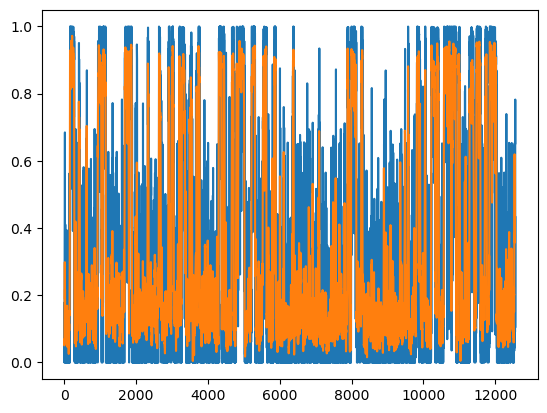

In [146]:
def moving_average(data, window_size):
    """
    Smooth the data using a moving average.

    Parameters:
    data (numpy array): The input data to smooth.
    window_size (int): The size of the moving window.

    Returns:
    numpy array: The smoothed data.
    """
    return np.convolve(data, np.ones(window_size) / window_size, mode='valid')

# Example usage
window_size = 10
smoothed_data = moving_average(Q, window_size)

plt.plot(Q)
plt.plot(smoothed_data)
print(smoothed_data)

In [147]:
Q_add_m1s = np.where(smoothed_data < 0.10, -1, smoothed_data)
Q_add_1s = np.where(Q_add_m1s > 0.90, 1, Q_add_m1s)
Q_add_0s = np.where(((Q_add_1s < 1) & (Q_add_1s > -1)), 0,  Q_add_1s)

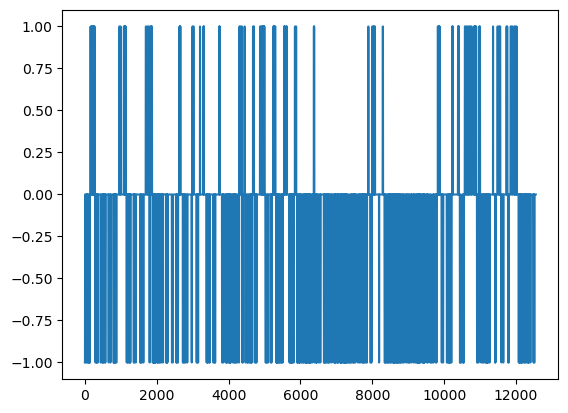

In [148]:
plt.plot(Q_add_0s)

In [149]:
upper = False 
lower = False 
transition_fwd = []

for i, q in enumerate(Q_add_0s): 
    if q == 0 and upper and lower: 
        transition_fwd.append(i)
        upper = False 
        lower = False 
    
    elif (q == 0) and (len(transition_fwd) > 0):
        if transition_fwd[-1] + 1 == i: 
            transition_fwd.append(i)     

    elif q == 1: 
        upper = True 
    
    elif q == -1: 
        lower = True


In [150]:
upper = False 
lower = False 
transition_rev = []

for i, q in enumerate(Q_add_0s[::-1]): 
    if q == 0 and upper and lower: 
        transition_rev.append(i)
        upper = False 
        lower = False 
    
    elif (q == 0) and (len(transition_rev) > 0):
        if transition_rev[-1] + 1 == i: 
            transition_rev.append(i)     

    elif q == 1: 
        upper = True 
    
    elif q == -1: 
        lower = True

In [151]:
transition_rev_ = np.arange(len(Q_add_0s))[::-1][transition_rev]

In [152]:
transition_paths = np.intersect1d(transition_fwd, transition_rev_)

(10000.0, 11000.0)

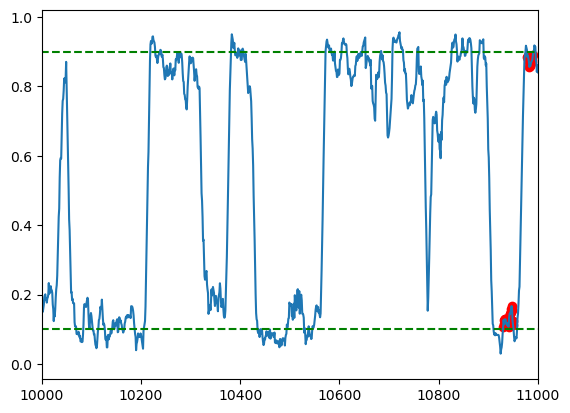

In [153]:
plt.plot(np.arange(len(smoothed_data)), smoothed_data)
plt.scatter(np.arange(len(smoothed_data))[transition_paths], smoothed_data[transition_paths], color="red")
plt.plot(np.arange(len(smoothed_data)), [0.9]*len(smoothed_data), linestyle="--" ,color="green" )
plt.plot(np.arange(len(smoothed_data)), [0.1]*len(smoothed_data), linestyle="--" ,color="green" )

plt.xlim(10000, 11000)

In [154]:
transition_paths

array([ 2997,  2998,  2999,  3000,  3001,  3002,  3003,  3004,  3005,
        3006,  3007,  3008,  3009,  3010,  3011,  3012,  3013,  4680,
        4681,  4682,  4683,  4684,  4685,  4686,  4687,  4688,  4689,
        4690,  4691,  4692,  4693,  4694,  4695,  4696,  4697,  4698,
        5847,  5848,  5849,  5850,  5851,  5852,  5853,  5854,  5855,
        5856,  5857,  5858,  5859,  5860,  5861,  5862,  5863,  5864,
        5865,  5866,  5867,  5868,  5869,  5870,  5871,  5872,  5873,
        5874,  5875,  5876,  5877,  6375,  6376,  6377,  8189,  8190,
        8191,  8192,  8193,  8194,  8195,  8196,  8197,  8198,  8199,
        8200,  8201,  8202,  8203,  8204,  8205,  8206,  8207,  8208,
        8209,  8210,  8211,  8212,  8213,  8214,  8215,  8216,  8217,
        8218,  8219,  8220,  8221,  8222,  8223,  8224,  8225,  8226,
        8227,  8228,  8229,  8230,  8231,  8232,  8233,  8234,  8235,
        8236,  8237,  8238,  8239,  8240,  8241,  8242,  8243,  8244,
        8245,  8246,

This is not entirely right. What I need is something that reads and adds to a list and saves once it goes past another threshold. 

In [155]:
def find_extended_zeros(sequence, min_zeros=1):
    extended_zeros_positions = []
    n = len(sequence)
    i = 0
    
    while i < n:
        # Find the first occurrence of 1 or -1
        while i < n and sequence[i] not in [1, -1]:
            i += 1
        
        if i == n:
            break
        
        start = i
        start_char = sequence[i]
        i += 1
        
        # Find the first occurrence of the opposite character, resetting if the same character is encountered again
        while i < n and sequence[i] != -start_char:
            if sequence[i] == start_char:
                start = i
                start_char = sequence[i]
            i += 1
        
        if i == n:
            break
        
        # Check the number of zeros between start_char and -start_char
        zeros_count = sequence[start + 1:i].count(0)
        
        if zeros_count >= min_zeros:
            extended_zeros_positions.append((start, i, zeros_count))
        
        i += 1
    
    return extended_zeros_positions

min_zeros = 2
extended_zeros_fwd = find_extended_zeros(list(Q_add_0s), min_zeros)
extended_zeros_rev = find_extended_zeros(list(Q_add_0s[::-1]), min_zeros)

In [156]:
path_fwd = []
for tup in extended_zeros_fwd:
    indxs = [i for i in range(tup[0],tup[1])]
    path_fwd.extend(indxs)

In [157]:
path_rev = []
re_index = np.arange(len(Q_add_0s))[::-1]
print(tup)
for tup in extended_zeros_rev:
    indxs = [i for i in range(tup[0],tup[1])]
    path_rev.extend(re_index[indxs])

(12014, 12072, 57)


In [158]:
transition_paths = np.intersect1d(np.array(path_fwd), np.array(path_rev))

In [159]:
transition_paths

array([  136,   137,   138, ..., 12069, 12070, 12071])

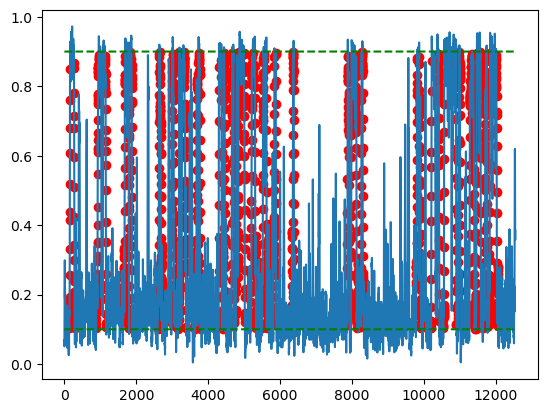

In [161]:
plt.plot(np.arange(len(smoothed_data)),smoothed_data)
plt.scatter(np.arange(len(smoothed_data))[transition_paths], smoothed_data[transition_paths], color="red")
plt.plot(np.arange(len(smoothed_data)), [0.9]*len(smoothed_data), linestyle="--" ,color="green" )
plt.plot(np.arange(len(smoothed_data)), [0.1]*len(smoothed_data), linestyle="--" ,color="green" )

#plt.xlim(4000, 6000)

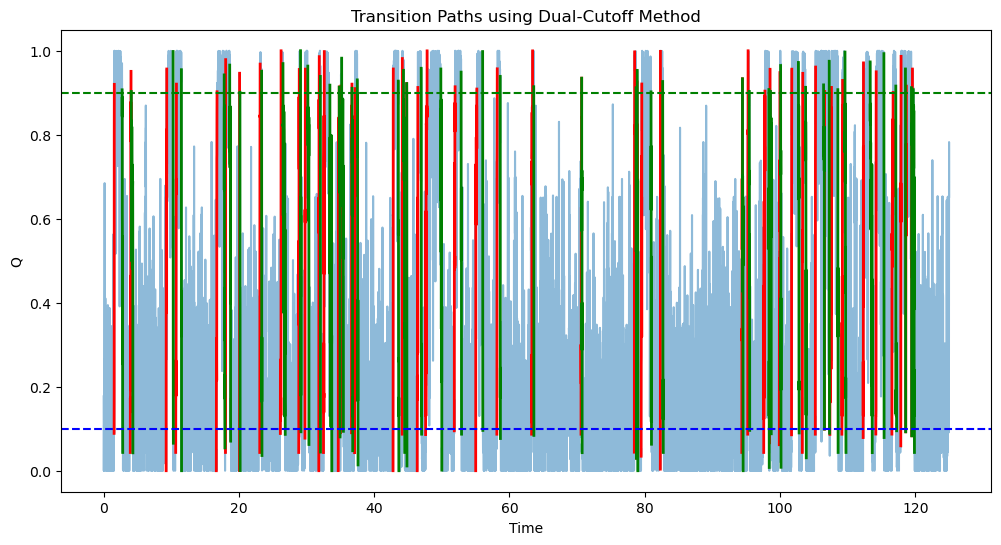

In [167]:
# work with grace tolu and keren
time=np.linspace(0,125,n_frames)
Q=1/(1+np.exp(10*(Traj_CA_Distnaces-(Native_Contact_Distances_nframes+1))))
Q_sum=np.sum(Q,axis=0)
Q_sum=np.sum(Q,axis=0)
Q=Q_sum/len(Native_CA_Distances)
# Organize Q values
Q_add_m1s = np.where(Q < 0.10, -1, Q)
Q_add_1s = np.where(Q_add_m1s > 0.90, 1, Q_add_m1s)
Q_add_0s = np.where((Q_add_1s != 1) & (Q_add_1s != -1), 0, Q_add_1s)
# Define cutoff thresholds
folded_threshold = 0.9
unfolded_threshold = 0.1
# Identify folding and unfolding paths
folding_paths = []
unfolding_paths = []
in_transition = False
start_index = None
for i in range(1, len(Q_add_0s)):
    if Q_add_0s[i-1] == -1 and Q_add_0s[i] == 0:
        in_transition = True
        start_index = i-1
    elif in_transition and Q_add_0s[i] == 1:
        if Q_add_0s[start_index:i].tolist().count(1) == 0:
            end_index = i
            folding_paths.append((time[start_index], time[end_index]))
        in_transition = False
    elif Q_add_0s[i-1] == 1 and Q_add_0s[i] == 0:
        in_transition = True
        start_index = i-1
    elif in_transition and Q_add_0s[i] == -1:
        if Q_add_0s[start_index:i].tolist().count(-1) == 0:
            end_index = i
            unfolding_paths.append((time[start_index], time[end_index]))
        in_transition = False
# Plot the transition paths
plt.figure(figsize=(12, 6))
plt.plot(time, Q, label='Q (Reaction Coordinate)', alpha=0.5)
# Highlight folding paths
for start, end in folding_paths:
    transition_indices = (time >= start) & (time <= end)
    plt.plot(time[transition_indices], Q[transition_indices], color='red', linewidth=2, label='Folding Path')
# Highlight unfolding paths
for start, end in unfolding_paths:
    transition_indices = (time >= start) & (time <= end)
    plt.plot(time[transition_indices], Q[transition_indices], color='green', linewidth=2, label='Unfolding Path')
# Mark thresholds for folded and unfolded states
plt.axhline(folded_threshold, color='g', linestyle='--', label='Folded Threshold')
plt.axhline(unfolded_threshold, color='b', linestyle='--', label='Unfolded Threshold')
# Customize the plot
plt.xlabel('Time')
plt.ylabel('Q')
#plt.xlim(50,60)
plt.title('Transition Paths using Dual-Cutoff Method')
plt.show()

In [166]:
# work with grace, keren, and tolu 
# Define thresholds for path duration
short_path_threshold = .2
long_path_threshold = .2
# Initialize lists to store longer and shorter paths
long_folding_paths = []
short_folding_paths = []
long_unfolding_paths = []
short_unfolding_paths = []
# Iterate through folding paths to categorize them as long or short
for start, end in folding_paths:
    path_duration = end - start
    if path_duration > long_path_threshold:
        long_folding_paths.append((start, end))
    else:
        short_folding_paths.append((start, end))
# Iterate through unfolding paths to categorize them as long or short
for start, end in unfolding_paths:
    path_duration = end - start
    if path_duration > long_path_threshold:
        long_unfolding_paths.append((start, end))
    else:
        short_unfolding_paths.append((start, end))
# Print or use the categorized paths as needed
print("Long Folding Paths:", long_folding_paths)
print("Short Folding Paths:", short_folding_paths)
print("Long Unfolding Paths:", long_unfolding_paths)
print("Short Unfolding Paths:", short_unfolding_paths)

Long Folding Paths: [(47.599139990444336, 47.81812390508043), (107.37179487179486, 107.6007326007326)]
Short Folding Paths: [(1.5428412167542602, 1.5727026596591813), (3.931756649147953, 4.041248606465998), (9.23713967192228, 9.326724000637043), (10.650581302755215, 10.76007326007326), (16.652731326644368, 16.762223283962413), (18.006450071667462, 18.036311514572382), (20.076843446408663, 20.096751075011944), (23.07294155120242, 23.132664437012263), (26.11880872750438, 26.228300684822422), (28.836200031852204, 28.915830546265326), (29.76190476190476, 29.821627647714603), (31.80243669374104, 31.872113393852523), (32.499203694855865, 32.61864946647555), (34.679089026915115, 34.82839624143972), (35.01751871317089, 35.07724159898073), (36.63999044433827, 36.70966714444975), (37.09786590221373, 37.19740404523013), (42.78149386845039, 42.82130912565695), (44.13521261347348, 44.15512024207676), (44.76230291447683, 44.80211817168339), (46.35491320273929, 46.45445134575569), (51.83946488294314,